In [ ]:
!pip install gputil psutil gputil matplotlib numpy

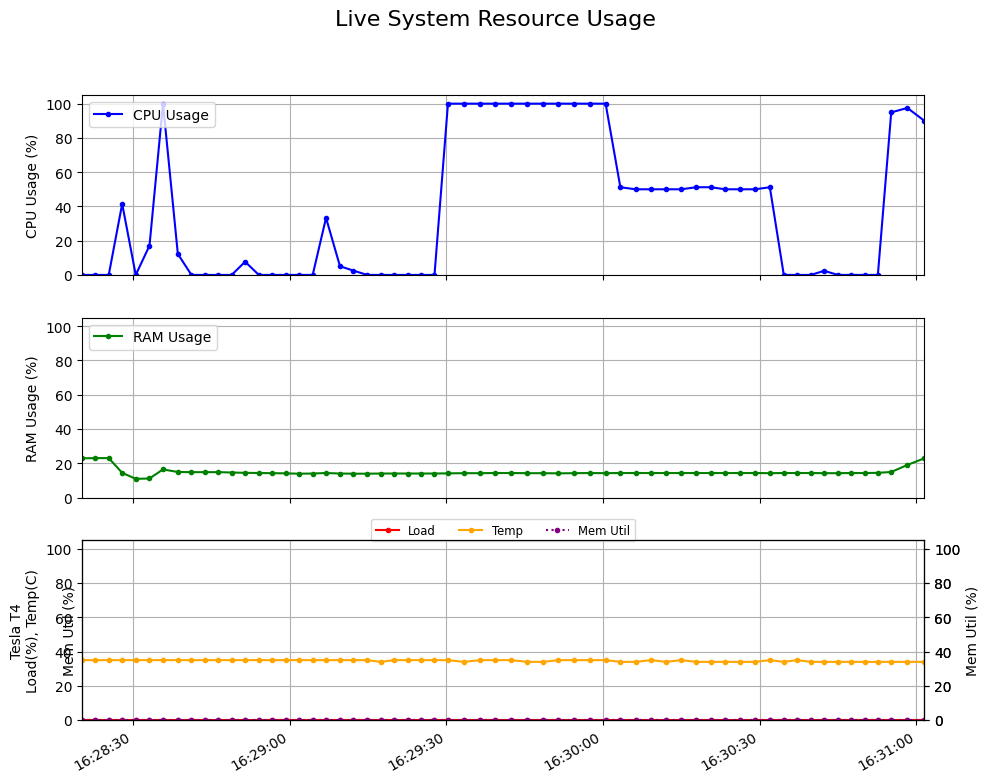

<Figure size 640x480 with 0 Axes>

In [ ]:
import psutil
import platform
import os
import datetime
import time
import collections
import warnings

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np  # Make sure numpy is imported
from IPython.display import display, clear_output

# --- Configuration ---
UPDATE_INTERVAL_SECONDS = 2.0 # How often to update (seconds)
HISTORY_LENGTH = 60         # How many data points to keep for plotting (e.g., 60 points * 2s/point = 120s history)
CHECK_GPU = True            # Set to True to attempt GPU monitoring (requires GPUtil and NVIDIA GPU+drivers)

# --- Data Storage ---
# Use deque for efficient fixed-size history
# Initialize numeric deques with np.nan to match HISTORY_LENGTH
# Timestamps deque starts empty and grows
history = {
    'timestamps': collections.deque(maxlen=HISTORY_LENGTH),
    'cpu_percent': collections.deque([np.nan] * HISTORY_LENGTH, maxlen=HISTORY_LENGTH),
    'ram_percent': collections.deque([np.nan] * HISTORY_LENGTH, maxlen=HISTORY_LENGTH),
    'gpu_stats': {} # Dictionary to hold deque lists for each GPU's metrics
}
gpu_ids = [] # To store the IDs of detected GPUs

# --- Helper Function ---
def format_bytes(bytes_val):
    """Converts bytes to a human-readable format (KB, MB, GB, etc.)."""
    if bytes_val < 1024:
        return f"{bytes_val} B"
    elif bytes_val < 1024**2:
        return f"{bytes_val/1024:.2f} KB"
    elif bytes_val < 1024**3:
        return f"{bytes_val/1024**2:.2f} MB"
    elif bytes_val < 1024**4:
        return f"{bytes_val/1024**3:.2f} GB"
    else:
        return f"{bytes_val/1024**4:.2f} TB"

# --- Resource Fetching Functions (Simplified for plotting) ---

def get_current_stats():
    """Fetches the current values for metrics we want to plot."""
    stats = {}
    stats['timestamp'] = datetime.datetime.now()
    stats['cpu_percent'] = psutil.cpu_percent(interval=0.1) # Shorter interval for faster updates
    stats['ram_percent'] = psutil.virtual_memory().percent

    # --- GPU Stats ---
    stats['gpu'] = {} # Dictionary to hold current stats for each GPU
    if CHECK_GPU:
        global gpu_ids # Allow modification of the global list
        try:
            import GPUtil
            gpus = GPUtil.getGPUs()
            if not gpus and not gpu_ids: # Only warn once if no GPUs initially
                # Check if warning already logged to avoid repetition
                if 'gpu_no_gpu_logged' not in globals():
                    warnings.warn("No NVIDIA GPU detected or nvidia-smi not found.")
                    globals()['gpu_no_gpu_logged'] = True
                history['gpu_stats'] = {} # Ensure it's empty

            current_gpu_ids = [gpu.id for gpu in gpus]

            # Initialize deques if new GPUs are detected or first run
            # Also handle if gpu_ids exists but history is empty (e.g., after error)
            if (not history['gpu_stats'] and gpus) or (set(current_gpu_ids) != set(gpu_ids)):
                 gpu_ids = current_gpu_ids
                 history['gpu_stats'] = {} # Reset stats if GPU set changes
                 for gpu_id in gpu_ids:
                     history['gpu_stats'][gpu_id] = {
                         'load': collections.deque(maxlen=HISTORY_LENGTH),
                         'mem_util': collections.deque(maxlen=HISTORY_LENGTH),
                         'temp': collections.deque(maxlen=HISTORY_LENGTH)
                     }
                     # Initialize with np.nan to match HISTORY_LENGTH
                     for _ in range(HISTORY_LENGTH):
                         history['gpu_stats'][gpu_id]['load'].append(np.nan)
                         history['gpu_stats'][gpu_id]['mem_util'].append(np.nan)
                         history['gpu_stats'][gpu_id]['temp'].append(np.nan)


            # Get current stats for detected GPUs
            for gpu in gpus:
                if gpu.id in history['gpu_stats']: # Only track GPUs we initialized for
                    stats['gpu'][gpu.id] = {
                        'load': gpu.load * 100, # Percentage
                        'mem_util': gpu.memoryUtil * 100, # Percentage
                        'temp': gpu.temperature,
                        'name': gpu.name # Store name for display
                    }

        except ImportError:
            if 'gpu_import_error_logged' not in globals(): # Log only once
                 warnings.warn("GPUtil library not found. Cannot check GPU status. Install with: pip install gputil")
                 globals()['gpu_import_error_logged'] = True
            history['gpu_stats'] = {} # Ensure it's empty
            gpu_ids = [] # Reset GPU ids
        except Exception as e:
            if 'gpu_runtime_error_logged' not in globals(): # Log only once
                warnings.warn(f"Could not get GPU info: {e}")
                globals()['gpu_runtime_error_logged'] = True
            # Keep existing history structure but don't update with new data points this cycle
            pass # Don't overwrite stats['gpu'] if there was an error fetching

    return stats

# --- Plotting Function ---

# Initialize plot variables globally
fig, axes = None, None

def setup_plots():
    """Creates the initial figure and axes based on detected resources."""
    global fig, axes, gpu_ids

    # Determine number of plots needed dynamically
    num_gpus = len(gpu_ids) if CHECK_GPU else 0
    num_plots = 2 + num_gpus # CPU, RAM, + 1 plot per GPU

    if num_plots < 2: # Should always have at least CPU and RAM
        print("Warning: Could not determine plots for CPU/RAM.")
        return False

    # Close previous figure if re-initializing (e.g., GPU detected later)
    if fig:
        plt.close(fig)

    # Adjust figsize and layout based on number of plots
    figsize_height = 3 * num_plots
    fig, axes = plt.subplots(num_plots, 1, figsize=(10, figsize_height), sharex=True)
    if num_plots == 1: # Handle unlikely case of only one plot
        axes = [axes] # Make it iterable

    # Configure CPU plot (Index 0)
    axes[0].set_ylabel('CPU Usage (%)')
    axes[0].set_ylim(0, 105)
    axes[0].grid(True)

    # Configure RAM plot (Index 1)
    axes[1].set_ylabel('RAM Usage (%)')
    axes[1].set_ylim(0, 105)
    axes[1].grid(True)

    # Configure GPU plots (Indices 2 onwards)
    gpu_plot_index = 2
    gpu_names = {} # Temporarily fetch names for titles
    if CHECK_GPU and num_gpus > 0:
       try:
           import GPUtil
           temp_gpus = GPUtil.getGPUs()
           gpu_names = {gpu.id: gpu.name for gpu in temp_gpus if gpu.id in gpu_ids}
       except Exception as e:
           print(f"Note: Could not fetch GPU names for plot titles: {e}")

    for i, gpu_id in enumerate(gpu_ids):
        plot_idx = gpu_plot_index + i
        if plot_idx < len(axes): # Check index bounds
            ax_gpu = axes[plot_idx]
            gpu_name = gpu_names.get(gpu_id, f"GPU {gpu_id}")
            ax_gpu.set_ylabel(f'{gpu_name}\nLoad(%), Temp(C)')
            ax_gpu.set_ylim(0, 105)
            ax_gpu.grid(True)
            # Add a secondary y-axis for Memory Utilization
            ax_gpu_mem = ax_gpu.twinx()
            ax_gpu_mem.set_ylabel('Mem Util (%)')
            ax_gpu_mem.set_ylim(0, 105)
            # Legends will be added dynamically during update_plot

    # Configure X-axis (shared) - applied to the last axes object
    axes[-1].set_xlabel('Time')
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    fig.autofmt_xdate() # Auto-rotate date labels

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title/label overlap
    fig.suptitle("Live System Resource Usage", fontsize=16, y=0.99) # Add title slightly higher
    return True


def update_plot(current_stats):
    """Appends new data and redraws the plot."""
    global fig, axes, history, gpu_ids

    if fig is None or axes is None:
        # Attempt to set up plots if they weren't ready
        if not setup_plots():
             print("Plot setup failed. Cannot update.")
             return
        # If setup succeeded, fig/axes are now set globally

    # --- Append new data ---
    timestamp = current_stats['timestamp']
    history['timestamps'].append(timestamp) # Append timestamp first

    # Append CPU/RAM, handle potential None if psutil fails (unlikely)
    history['cpu_percent'].append(current_stats.get('cpu_percent', np.nan))
    history['ram_percent'].append(current_stats.get('ram_percent', np.nan))

    # Append GPU data safely
    gpu_data_received = current_stats.get('gpu', {})
    for gpu_id in gpu_ids:
        if gpu_id in gpu_data_received:
            gpu_data = gpu_data_received[gpu_id]
            history['gpu_stats'][gpu_id]['load'].append(gpu_data.get('load', np.nan))
            history['gpu_stats'][gpu_id]['mem_util'].append(gpu_data.get('mem_util', np.nan))
            history['gpu_stats'][gpu_id]['temp'].append(gpu_data.get('temp', np.nan))
        else:
            # Append nan if this GPU's data wasn't available this cycle
            # Check deque lengths to avoid over-appending if timestamp wasn't added yet
             if len(history['timestamps']) > len(history['gpu_stats'][gpu_id]['load']):
                history['gpu_stats'][gpu_id]['load'].append(np.nan)
                history['gpu_stats'][gpu_id]['mem_util'].append(np.nan)
                history['gpu_stats'][gpu_id]['temp'].append(np.nan)


    # --- Redrawing ---
    clear_output(wait=True) # Clear the previous plot in the cell

    timestamps_list = list(history['timestamps'])
    current_len = len(timestamps_list) # Number of actual timestamps collected

    if current_len == 0: # Don't plot if no data yet
        display(fig)
        plt.pause(0.01)
        return

    # --- Prepare data for plotting (Get full history and slice) ---
    # Slice the numeric data deques to match the number of timestamps collected
    # This takes the *last* 'current_len' items, handling the initial fill phase
    cpu_data_to_plot = list(history['cpu_percent'])[-current_len:]
    ram_data_to_plot = list(history['ram_percent'])[-current_len:]

    # --- Plot CPU (Index 0) ---
    axes[0].clear()
    axes[0].plot(timestamps_list, cpu_data_to_plot, label='CPU Usage', color='blue', marker='.', linestyle='-')
    axes[0].set_ylabel('CPU Usage (%)')
    axes[0].set_ylim(0, 105)
    axes[0].grid(True)
    axes[0].legend(loc='upper left')

    # --- Plot RAM (Index 1) ---
    axes[1].clear()
    axes[1].plot(timestamps_list, ram_data_to_plot, label='RAM Usage', color='green', marker='.', linestyle='-')
    axes[1].set_ylabel('RAM Usage (%)')
    axes[1].set_ylim(0, 105)
    axes[1].grid(True)
    axes[1].legend(loc='upper left')


    # --- Plot GPUs (Indices 2 onwards) ---
    gpu_plot_index = 2
    latest_gpu_names = {gid: stats.get('name', f"GPU {gid}") for gid, stats in current_stats.get('gpu', {}).items()}

    for i, gpu_id in enumerate(gpu_ids):
        plot_idx = gpu_plot_index + i
        if plot_idx < len(axes): # Ensure axes index is valid
            ax_gpu = axes[plot_idx]
            ax_gpu.clear() # Clear primary axis

            # --- Prepare Sliced GPU Data ---
            gpu_load_to_plot = np.array(list(history['gpu_stats'][gpu_id]['load'])[-current_len:], dtype=float)
            gpu_temp_to_plot = np.array(list(history['gpu_stats'][gpu_id]['temp'])[-current_len:], dtype=float)
            gpu_mem_to_plot = np.array(list(history['gpu_stats'][gpu_id]['mem_util'])[-current_len:], dtype=float)

            # --- Plot on Primary Axis (Load, Temp) ---
            line_load, = ax_gpu.plot(timestamps_list, gpu_load_to_plot, label='Load', color='red', marker='.', linestyle='-')
            line_temp, = ax_gpu.plot(timestamps_list, gpu_temp_to_plot, label='Temp', color='orange', marker='.', linestyle='-')
            gpu_name = latest_gpu_names.get(gpu_id, f"GPU {gpu_id}")
            ax_gpu.set_ylabel(f'{gpu_name}\nLoad(%), Temp(C)')
            ax_gpu.set_ylim(0, 105)
            ax_gpu.grid(True)

            # --- Plot on Secondary Axis (Mem Util) ---
            # Need to check if a twin axis already exists and clear it, or create it
            if hasattr(ax_gpu, 'twin_ax_gpu_mem'):
                 ax_gpu_mem = ax_gpu.twin_ax_gpu_mem
                 ax_gpu_mem.clear()
            else:
                 ax_gpu_mem = ax_gpu.twinx()
                 ax_gpu.twin_ax_gpu_mem = ax_gpu_mem # Store reference

            line_mem, = ax_gpu_mem.plot(timestamps_list, gpu_mem_to_plot, label='Mem Util', color='purple', marker='.', linestyle=':')
            ax_gpu_mem.set_ylabel('Mem Util (%)')
            ax_gpu_mem.set_ylim(0, 105)

            # --- Combine Legends ---
            lines = [line_load, line_temp, line_mem]
            labels = [l.get_label() for l in lines]
            # Adjust legend position if needed (e.g., upper center below title)
            ax_gpu.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3, fancybox=True, shadow=False, fontsize='small')
            ax_gpu_mem.legend().set_visible(False) # Hide the automatic legend for the twin axis


    # --- Final Formatting ---
    # Apply X-axis formatting to the *last* subplot's axis
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    # Set X limits dynamically based on the collected timestamps
    if len(timestamps_list) > 1:
       axes[-1].set_xlim(min(timestamps_list), max(timestamps_list))
    elif len(timestamps_list) == 1:
        # Handle single point - maybe show a small range around it
        time_delta = datetime.timedelta(seconds=HISTORY_LENGTH * UPDATE_INTERVAL_SECONDS / 2)
        axes[-1].set_xlim(timestamps_list[0] - time_delta, timestamps_list[0] + time_delta)

    fig.autofmt_xdate() # Rotate date labels if needed
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout (top margin for title)
    fig.suptitle("Live System Resource Usage", fontsize=16, y=0.99) # Reapply title

    display(fig) # Display the updated figure in the output cell
    plt.pause(0.01) # Small pause necessary for display update in loops


# --- Main Loop ---
try:
    print("Initializing live monitor...")
    # Fetch initial stats *before* setting up plots to know how many GPU plots are needed
    initial_stats = get_current_stats()

    if not setup_plots():
         raise SystemExit("Failed to setup plots. Exiting.")

    # Update plot with the first data point *after* setup
    update_plot(initial_stats)

    print(f"Starting live monitoring... Update interval: {UPDATE_INTERVAL_SECONDS}s. History: {HISTORY_LENGTH} points.")
    print("Press the Square 'Interrupt Kernel' button in Jupyter toolbar to stop.")

    while True:
        current_stats = get_current_stats()

        # Check if GPU configuration changed (e.g., GPUtil started working or GPUs appeared/disappeared)
        current_gpu_ids = list(current_stats.get('gpu', {}).keys())
        if CHECK_GPU and set(current_gpu_ids) != set(gpu_ids):
             print("\nGPU configuration change detected. Re-initializing plots...")
             # Update global gpu_ids list based on current detection
             # get_current_stats already handles initializing history['gpu_stats']
             if not setup_plots(): # Re-setup plots with new number of axes
                 print("Failed to re-initialize plots after GPU change. Stopping.")
                 break
             print("Plots re-initialized.")
             # The next update_plot call will use the new structure

        update_plot(current_stats)
        time.sleep(UPDATE_INTERVAL_SECONDS)

except KeyboardInterrupt:
    print("\nMonitoring stopped by user (KeyboardInterrupt).")
except Exception as e:
    print(f"\nAn error occurred during monitoring: {e}")
    import traceback
    traceback.print_exc() # Print detailed traceback for debugging
finally:
    # Close the plot when done to release resources
    if fig:
        plt.close(fig)
        print("Plot closed.")
    # Clear any lingering globals used for warning flags
    for flag in ['gpu_no_gpu_logged', 'gpu_import_error_logged', 'gpu_runtime_error_logged']:
        if flag in globals():
            del globals()[flag]
    print("Monitoring finished.")

In [3]:
import psutil
import platform
import os
import datetime
from IPython.display import display, HTML, clear_output
import time
import warnings

# --- Configuration ---
# Set to True to monitor continuously, False for a single snapshot
CONTINUOUS_MONITORING = False
UPDATE_INTERVAL_SECONDS = 5 # How often to update if CONTINUOUS_MONITORING is True

# Set to True to attempt GPU monitoring (requires GPUtil and NVIDIA GPU+drivers)
CHECK_GPU = True

# --- Helper Function ---
def format_bytes(bytes_val):
    """Converts bytes to a human-readable format (KB, MB, GB, etc.)."""
    if bytes_val < 1024:
        return f"{bytes_val} B"
    elif bytes_val < 1024**2:
        return f"{bytes_val/1024:.2f} KB"
    elif bytes_val < 1024**3:
        return f"{bytes_val/1024**2:.2f} MB"
    elif bytes_val < 1024**4:
        return f"{bytes_val/1024**3:.2f} GB"
    else:
        return f"{bytes_val/1024**4:.2f} TB"

# --- Resource Fetching Functions ---

def get_system_info():
    """Gets basic system information."""
    info = {}
    uname = platform.uname()
    info['System'] = uname.system
    info['Node Name'] = uname.node
    info['Release'] = uname.release
    info['Version'] = uname.version
    info['Machine'] = uname.machine
    info['Processor'] = uname.processor
    boot_time = datetime.datetime.fromtimestamp(psutil.boot_time())
    info['Boot Time'] = boot_time.strftime("%Y-%m-%d %H:%M:%S")
    return info

def get_cpu_info():
    """Gets CPU usage information."""
    info = {}
    # Physical cores
    info['Physical Cores'] = psutil.cpu_count(logical=False)
    # Total cores
    info['Total Cores'] = psutil.cpu_count(logical=True)
    # CPU Usage (wait 1 sec for a more accurate reading)
    info['Total CPU Usage (%)'] = psutil.cpu_percent(interval=1)
    # Per-CPU Usage
    per_cpu_usage = psutil.cpu_percent(interval=1, percpu=True)
    info['Per CPU Usage (%)'] = per_cpu_usage
    return info

def get_memory_info():
    """Gets RAM and Swap memory usage."""
    info = {}
    # RAM
    svmem = psutil.virtual_memory()
    info['RAM Total'] = format_bytes(svmem.total)
    info['RAM Available'] = format_bytes(svmem.available)
    info['RAM Used'] = format_bytes(svmem.used)
    info['RAM Percentage (%)'] = svmem.percent
    # Swap
    try:
        swap = psutil.swap_memory()
        info['Swap Total'] = format_bytes(swap.total)
        info['Swap Free'] = format_bytes(swap.free)
        info['Swap Used'] = format_bytes(swap.used)
        info['Swap Percentage (%)'] = swap.percent
    except Exception as e:
        info['Swap Info'] = f"Could not retrieve swap info: {e}" # Handle systems without swap
    return info

def get_gpu_info():
    """Gets NVIDIA GPU usage information using GPUtil."""
    gpu_info_list = []
    if not CHECK_GPU:
        return ["GPU check disabled."]

    try:
        import GPUtil
    except ImportError:
        return ["GPUtil library not found. Cannot check GPU status. Install with: pip install gputil"]
    except Exception as e:
        return [f"Error importing GPUtil: {e}"]

    try:
        gpus = GPUtil.getGPUs()
        if not gpus:
            return ["No NVIDIA GPU detected or nvidia-smi not found."]

        for gpu in gpus:
            info = {}
            info['GPU ID'] = gpu.id
            info['Name'] = gpu.name
            info['Load (%)'] = f"{gpu.load*100:.1f}"
            info['Memory Used'] = format_bytes(gpu.memoryUsed * 1024**2) # GPUtil gives MB
            info['Memory Total'] = format_bytes(gpu.memoryTotal * 1024**2) # GPUtil gives MB
            info['Memory Util (%)'] = f"{gpu.memoryUtil*100:.1f}"
            info['Temperature (°C)'] = f"{gpu.temperature}"
            # info['UUID'] = gpu.uuid # Uncomment if needed
            gpu_info_list.append(info)
        return gpu_info_list
    except Exception as e:
        # Catch potential errors like nvidia-smi not being found
        warnings.warn(f"Could not get GPU info: {e}")
        return [f"Error getting GPU details: {e}"]


def get_disk_info():
    """Gets disk usage information for relevant partitions."""
    disk_info_list = []
    partitions = psutil.disk_partitions()
    seen_devices = set() # Avoid duplicates if mounted multiple times

    # Prioritize common mount points
    mount_points_to_check = ['/', os.path.expanduser("~"), os.getcwd()]
    checked_devices = set()

    # Check specific important mount points first
    for path in mount_points_to_check:
      try:
          usage = psutil.disk_usage(path)
          # Find the partition corresponding to this path to get device/fstype
          found_part = None
          for p in partitions:
              if path.startswith(p.mountpoint): # Basic check
                  # More robust check might be needed depending on OS and mount structure
                  if p.device not in checked_devices:
                      found_part = p
                      break
          if found_part:
              info = {}
              info['Mount Point'] = found_part.mountpoint
              info['Device'] = found_part.device
              info['File System Type'] = found_part.fstype
              info['Total Size'] = format_bytes(usage.total)
              info['Used'] = format_bytes(usage.used)
              info['Free'] = format_bytes(usage.free)
              info['Percentage Used (%)'] = usage.percent
              disk_info_list.append(info)
              checked_devices.add(found_part.device)
              seen_devices.add(found_part.device) # Add to overall seen set
      except FileNotFoundError:
        pass # Path might not exist (e.g. home on some minimal systems)
      except Exception as e:
        warnings.warn(f"Could not get disk usage for {path}: {e}")

    # # Optionally, add all other physical disks (can be verbose)
    # for partition in partitions:
    #     # Try to filter out cd-roms, memory-based fs, etc.
    #     # Adjust 'opts' check based on your OS ('rw','fixed' might be useful)
    #     # Check if device starts with typical disk identifiers (depends on OS)
    #     is_physical = 'cdrom' not in partition.opts and \
    #                   partition.fstype not in ['tmpfs', 'devtmpfs', 'squashfs'] and \
    #                   not partition.device.startswith('/dev/loop') and \
    #                   partition.device not in seen_devices

    #     if is_physical:
    #         try:
    #             usage = psutil.disk_usage(partition.mountpoint)
    #             info = {}
    #             info['Mount Point'] = partition.mountpoint
    #             info['Device'] = partition.device
    #             info['File System Type'] = partition.fstype
    #             info['Total Size'] = format_bytes(usage.total)
    #             info['Used'] = format_bytes(usage.used)
    #             info['Free'] = format_bytes(usage.free)
    #             info['Percentage Used (%)'] = usage.percent
    #             disk_info_list.append(info)
    #             seen_devices.add(partition.device)
    #         except Exception as e:
    #             # Ignore errors like permission denied for some mount points
    #             # print(f"Could not get usage for {partition.mountpoint}: {e}")
    #             pass

    return disk_info_list

# --- Display Function ---

def display_usage():
    """Fetches all resource info and formats it for display."""
    html_content = "<h2>System Resource Usage</h2>"

    # System Info
    html_content += "<h3>System Information</h3><pre>"
    sys_info = get_system_info()
    for key, value in sys_info.items():
        html_content += f"{key:<15}: {value}\n"
    html_content += "</pre>"

    # CPU Info
    html_content += "<h3>CPU Usage</h3><pre>"
    cpu_info = get_cpu_info()
    html_content += f"{'Physical Cores':<20}: {cpu_info['Physical Cores']}\n"
    html_content += f"{'Total Cores':<20}: {cpu_info['Total Cores']}\n"
    html_content += f"{'Total CPU Usage (%)':<20}: {cpu_info['Total CPU Usage (%)']:.1f}%\n"
    html_content += "Per CPU Usage (%):\n"
    for i, usage in enumerate(cpu_info['Per CPU Usage (%)']):
        html_content += f"  Core {i:<2}: {usage:.1f}%\n"
    html_content += "</pre>"

    # Memory Info
    html_content += "<h3>Memory Usage</h3><pre>"
    mem_info = get_memory_info()
    html_content += f"{'RAM Total':<20}: {mem_info['RAM Total']}\n"
    html_content += f"{'RAM Available':<20}: {mem_info['RAM Available']}\n"
    html_content += f"{'RAM Used':<20}: {mem_info['RAM Used']}\n"
    html_content += f"{'RAM Percentage (%)':<20}: {mem_info['RAM Percentage (%)']:.1f}%\n"
    if 'Swap Info' in mem_info:
         html_content += f"{'Swap':<20}: {mem_info['Swap Info']}\n"
    elif 'Swap Total' in mem_info:
        html_content += "--- Swap ---\n"
        html_content += f"{'Swap Total':<20}: {mem_info['Swap Total']}\n"
        html_content += f"{'Swap Free':<20}: {mem_info['Swap Free']}\n"
        html_content += f"{'Swap Used':<20}: {mem_info['Swap Used']}\n"
        html_content += f"{'Swap Percentage (%)':<20}: {mem_info['Swap Percentage (%)']:.1f}%\n"
    html_content += "</pre>"

    # GPU Info
    html_content += "<h3>GPU Usage (NVIDIA)</h3>"
    gpu_output = get_gpu_info()
    if isinstance(gpu_output, list) and gpu_output and isinstance(gpu_output[0], dict):
        html_content += "<pre>"
        for i, gpu_data in enumerate(gpu_output):
            html_content += f"--- GPU {gpu_data.get('GPU ID', i)} ---\n"
            for key, value in gpu_data.items():
                 if key != 'GPU ID': # Already shown in header
                    html_content += f"  {key:<18}: {value}\n"
        html_content += "</pre>"
    elif isinstance(gpu_output, list): # List of strings (errors/messages)
         html_content += "<pre>" + "\n".join(gpu_output) + "</pre>"
    else:
         html_content += "<pre>Unexpected GPU info format.</pre>"


    # Disk Info
    html_content += "<h3>Disk Usage</h3>"
    disk_output = get_disk_info()
    if disk_output:
        html_content += "<pre>"
        for i, disk_data in enumerate(disk_output):
             html_content += f"--- Disk {i} ---\n"
             for key, value in disk_data.items():
                  html_content += f"  {key:<18}: {value}\n"
        html_content += "</pre>"
    else:
         html_content += "<pre>No relevant disk partitions found or could not read usage.</pre>"

    # Add timestamp
    html_content += f"<hr><p><i>Last updated: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</i></p>"

    # Display using IPython.display
    clear_output(wait=True) # Clears previous output in the cell
    display(HTML(html_content))

# --- Execution ---

if CONTINUOUS_MONITORING:
    try:
        print(f"Starting continuous monitoring. Update interval: {UPDATE_INTERVAL_SECONDS}s. Press Ctrl+C (or Kernel Interrupt) to stop.")
        while True:
            display_usage()
            time.sleep(UPDATE_INTERVAL_SECONDS)
    except KeyboardInterrupt:
        print("\nMonitoring stopped by user.")
    finally:
         # Optionally display one last time after stopping
         print("Displaying final snapshot...")
         display_usage()
else:
    print("Displaying single snapshot of resource usage...")
    display_usage()

In [ ]:
!pip cache purge

In [ ]:
!nvidia-smi